In [268]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

import time
import urllib

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import os
import re

from collections import Counter

import wordcloud
import matplotlib.pyplot as plt

from IPython.display import Image

import itertools

%matplotlib inline

from konlpy.tag import Okt
import konlpy.tag
from ckonlpy.tag import Twitter as cTwitter

import codecs
from bs4 import BeautifulSoup
from konlpy.tag import Okt
from gensim.models import word2vec

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# matplotlib 한글 폰트 출력코드
# 출처 : 데이터공방( https://kiddwannabe.blog.me)

import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False  

In [92]:
name_news = {
    "chosun" : "조선일보",
    "donga" : "동아일보",
    "hankyoreh" : "한겨레",
    "kyunghyang" : "경향신문"
}

name_pos = {
    "Noun" : "명사",
    "Verb" : "동사"
}

# 제거할 패턴들 정의 (금칙어)
except_words = [
    r'\D+}\s\s',
    r'\[\D+\]',
    r'Copyrights\D+',
    r'사진\=뉴스타파',
    r'\/뉴시스',
    r'\/뉴스타파',
    r'뉴스타파 캡처',
    r'<사진>',
    r'사진\=',
    r'캡처',
    r'.\w{3} 동아닷컴 기자 \D+',
    r'.\w{3} \w+@donga.com\D+',
    r'.(\s)\w+@donga.com\D+',
    r'.\w{2}\/\w{3} 기자 \w+@hani.co.kr',
    r'\w{3} \w{3} \w{3} 기자 \w+@hani.co.kr',
    r'\w{3} 기자 \w+@hani.co.kr',
    r'▶ \D+',
    r'\w{3} 기자 \w+@kyunghyang.com',
    r'\w{3}·\w{3} 기자  \w+@kyunghyang.com',
    r'\t',
    '조선일보',
    '동아일보',
    '한겨레',
    '경향신문',
    '코로나',
    '<br/>',
    '</br>'
]

# 치환할 패턴
other_words1 = ['조국', '조 국', '조국 전 법무부 장관', '조 전 장관', '조국 전 법무장관']

headers = {
    'referer' : 'https://search.naver.com',
    'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36'
}

# 1. 텍스트 데이터 수집

- 기사 텍스트 수집 사이트 : https://www.bigkinds.or.kr/


- 검색 조건
    - 검색어 :     
    > ((조국) OR (조국 민정수석) OR (조국 청와대 민정수석) OR (조국 서울대학교 법학전문대학원 교수) OR (조국 서울대 교수) OR (서울대 법학전문대학원 조국 교수) OR (조국 교수) OR (조국 서울대 법학전문대학원 교수) OR (조국 법무부 장관 후보자) OR (조국 법무부 장관) OR (조국 법무장관) OR (조국 장관) OR (조국 전 법무부 장관) OR (조국 전 장관) OR (조국 전 법무장관) OR (조국 전 법무부 장관) OR (조국 전 법무부 장관)) AND ((회장) OR (민정수석) OR (새정치민주연합) OR (서울대학교) OR (혁신위원회) OR (대학교수) OR (위원) OR (한국경찰법학회) OR (청와대) OR (법학전문대학원) OR (서울대학교 법학전문대학원) OR (교수) OR (수석))
    
    
-     
    - 기간: **최근 1주**
    - 언론사: **조선일보, 동아일보, 경향신문, 한겨레**
    - 통합분류 : **정치**
    - 검색어처리 : **바이그램**


- **전체 페이징** 하여 기사별 데이터 추출(크롤링)하기
    - 추출항목 : **날짜 / 기사제목 / 언론사 / 기사본문**


- selenium 혹은 requests 혹은 둘을 혼합하여 사용 가능합니다
    - 크롤링 동작은 **하나의 셀**에 작성하세요
    

- **언론사 별** 로  DataFrame 담아서 출력하기
    - 변수명은 각각
        - df_chosun
        - df_donga
        - df_kyunghyang
        - df_hankyoreh
|날짜|제목|언론사|기사본문|
|-|-|-|-|
|...|...|...|...|
        
    




In [6]:
keyword = '((조국) OR (조국 민정수석) OR (조국 청와대 민정수석) OR (조국 서울대학교 법학전문대학원 교수) OR (조국 서울대 교수) OR (서울대 법학전문대학원 조국 교수) OR (조국 교수) OR (조국 서울대 법학전문대학원 교수) OR (조국 법무부 장관 후보자) OR (조국 법무부 장관) OR (조국 법무장관) OR (조국 장관) OR (조국 전 법무부 장관) OR (조국 전 장관) OR (조국 전 법무장관) OR (조국 전 법무부 장관) OR (조국 전 법무부 장관)) AND ((회장) OR (민정수석) OR (새정치민주연합) OR (서울대학교) OR (혁신위원회) OR (대학교수) OR (위원) OR (한국경찰법학회) OR (청와대) OR (법학전문대학원) OR (서울대학교 법학전문대학원) OR (교수) OR (수석))'

In [4]:
driver_path = r'C:\DevRoot\DataSet\bin\chromedriver.exe'
driver = webdriver.Chrome(driver_path)

In [5]:
url = ' https://www.bigkinds.or.kr/'
driver.get(url)

time.sleep(2)

# 검색 -> 상세 검색 진입 -> 언론사 탭(기본)
driver.find_element_by_id('total-search-key').send_keys(keyword)
driver.find_element_by_id('total-search-key').send_keys(Keys.TAB,Keys.TAB,Keys.ENTER)

# 언론사 4개 선택
for name_new in name_news:
    driver.find_element_by_id(name_news[name_new]).send_keys(Keys.ENTER)
    driver.find_element_by_id(name_news[name_new]).send_keys(Keys.SPACE)

# 기간 탭 -> 1주 클릭
driver.find_element_by_css_selector('a.tab-btn.search-tab_group').click()
driver.find_element_by_css_selector('#srch-tab1 > div > div.radio-btn-wp.col6 > span:nth-child(2) > label').click()

# 통합 분류 탭 -> 정치 선택
driver.find_element_by_css_selector('a.tab-btn.tab3.search-tab_group').click()
driver.find_element_by_css_selector('#srch-tab3 > ul > li:nth-child(1) > div > span:nth-child(3)').click()

# 상세검색 탭 -> '바이그램' select
driver.find_element_by_css_selector('a.tab-btn.tab5').click()
driver.find_element_by_xpath("//select[@id='search-filter-type']/option[text()='바이그램']").click()

# 검색 클릭
driver.find_element_by_css_selector('.btn.btn-md.btn-primary.news-search-btn').click()

time.sleep(2)

In [64]:
# 총페이지
total_page = driver.find_element_by_css_selector('#news-results-tab > div.data-result-ac.pc-only.paging-v2-wrp > div.data-result-btm > div > div > div > div > div:nth-child(6) > div').get_attribute('data-page')
# 현재페이지
page = driver.find_element_by_css_selector('#paging_news_result').get_attribute('data-page')

items_list = []
while True:
       
    print(f'{page}페이지 : 시작')
    elements = driver.find_elements_by_css_selector('#news-results > div')
    
    result = [
        {
            'docId' : element.get_attribute('data-id')
        }
        for element in elements
    ]
    
    
    for item in result:
        docId = item['docId']
        url = f'https://www.bigkinds.or.kr/news/detailView.do?docId={docId}&returnCnt=1&sectionDiv=1000'
        response = requests.get(url, headers=headers)
        data = response.json()

        item_list = [
            {
                "날짜" : data['detail']['DATE'],
                "제목" : data['detail']['TITLE'],
                "언론사" : data['detail']['PROVIDER'],
                "기사본문" : data['detail']['CONTENT'],
            }
        ]
        items_list = items_list + item_list
    
    if total_page == page: print('끝'); break  # 페이지가 같아지면 종료
        
    # 다음 페이지
    driver.find_element_by_css_selector('#news-results-tab > div.data-result-ac.pc-only.paging-v2-wrp > div.data-result-btm > div > div > div > div > div:nth-child(7) > a').click()
    
    # 2초 대기 : 페이징 로딩 되는 시간
    time.sleep(2)
    
    # 현재페이지
    page = driver.find_element_by_css_selector('#paging_news_result').get_attribute('data-page')
    

1페이지 : 시작
2페이지 : 시작
3페이지 : 시작
4페이지 : 시작
5페이지 : 시작
6페이지 : 시작
7페이지 : 시작
8페이지 : 시작
9페이지 : 시작
10페이지 : 시작
11페이지 : 시작
끝


In [66]:
df = pd.DataFrame(items_list)
df.head()

,날짜,제목,언론사,기사내용
0,20210603,"與초선 68명, 文대통령과 간담회… 조국·부동산 쓴소리는 없었다",조선일보,문재인 대통령이 3일 오전 청와대에서 더불어민주당 초선 모임인 ‘더민초 소속’ 의원...
1,20210603,권경애 “대깨문 맹동이 민주주의 파괴… 이젠 민주당이 악마 돼”,조선일보,‘조국 흑서’ 공동저자인 민주사회를 위한 변호사 모임(민변) 출신 권경애 변호사가 ...
2,20210603,친문 전재수 “윤로남불 안 되려면 尹수사 조국과 같은 잣대로 해야”,조선일보,"더불어민주당 친문(親文) 전재수 의원이 3일 “윤석열 전 검찰총장 본인의 문제, 장..."
3,20210603,"조국 “박용진, 왜 부정확한 말하나…내가 윤석열 천거?”",동아일보,조국 전 법무부 장관이 2일 더불어민주당 박용진 의원이 자신에 대해 확실하지 않은 ...
4,20210603,송영길 “조국 사태 어제부로 다 정리”… 與 ‘윤석열 때리기’ 올인,조선일보,"더불어민주당이 2일 이른바 ‘조국 사태’에 대해 사과한 가운데, 야권의 유력한 대선..."


In [72]:
# 결과
df_chosun = df[df['언론사'] == '조선일보']
df_chosun.reset_index(drop=True, inplace=True)
df_chosun

,날짜,제목,언론사,기사내용
0,20210603,"與초선 68명, 文대통령과 간담회… 조국·부동산 쓴소리는 없었다",조선일보,문재인 대통령이 3일 오전 청와대에서 더불어민주당 초선 모임인 ‘더민초 소속’ 의원...
1,20210603,권경애 “대깨문 맹동이 민주주의 파괴… 이젠 민주당이 악마 돼”,조선일보,‘조국 흑서’ 공동저자인 민주사회를 위한 변호사 모임(민변) 출신 권경애 변호사가 ...
2,20210603,친문 전재수 “윤로남불 안 되려면 尹수사 조국과 같은 잣대로 해야”,조선일보,"더불어민주당 친문(親文) 전재수 의원이 3일 “윤석열 전 검찰총장 본인의 문제, 장..."
3,20210603,송영길 “조국 사태 어제부로 다 정리”… 與 ‘윤석열 때리기’ 올인,조선일보,"더불어민주당이 2일 이른바 ‘조국 사태’에 대해 사과한 가운데, 야권의 유력한 대선..."
4,20210603,‘조국사태 사과’ 송영길에 들끓는 親文… 탄핵요구 靑국민청원까지,조선일보,"더불어민주당 송영길 대표가 2일 이른바 ‘조국 사태’에 대해 공식 사과한 가운데, ..."
5,20210603,조국 “저를 밟고 전진하라”… 1시간뒤 ‘책 10만부 돌파’ 자랑,조선일보,조국 전 법무부 장관은 2일 더불어민주당 송영길 대표가 ‘조국 사태’에 사과한 데 ...
6,20210603,"조국 사태 검찰·언론 탓했다… 與, 사과 같지 않은 ‘조국 사과’",조선일보,더불어민주당 송영길 대표가 2일 ‘조국 사태’와 관련해 “청년들의 상처받은 마음을 ...
7,20210602,"곽상도 “여럿 죽었는데…조국, 본인수사에만 사냥 운운 가증”",조선일보,"국민의힘 곽상도 의원이 2일 조국 전 법무부 장관의 회고록 출간과 관련, “본인과 ..."
8,20210602,"조국 소용돌이 vs 이준석 돌풍, 내년 대선이 보인다",조선일보,"두 개의 바람이 붑니다. 조국 바람, 그리고 이준석 바람입니다. <br/> <br/..."
9,20210602,與김한정 “당까지 부관참시” 조국사태 사과에 공개반발,조선일보,더불어민주당 내부에서 송영길 대표의 ‘조국사태 대국민사과’에 대한 공개적인 반발이 ...


In [73]:
# 결과
df_donga = df[df['언론사'] == '동아일보']
df_donga.reset_index(drop=True, inplace=True)
df_donga

,날짜,제목,언론사,기사내용
0,20210603,"조국 “박용진, 왜 부정확한 말하나…내가 윤석열 천거?”",동아일보,조국 전 법무부 장관이 2일 더불어민주당 박용진 의원이 자신에 대해 확실하지 않은 ...
1,20210603,조국 털어내고 윤석열 겨누는 與,동아일보,더불어민주당 송영길 대표가 ‘조국 사태’와 관련해 “수많은 청년들에게 좌절과 실망을...
2,20210603,조국 “날 밟고 전진하라”,동아일보,조국 전 법무부 장관이 2일 더불어민주당 송영길 대표의 사과 직후 “민주당은 이제 ...
3,20210603,"국민의힘 “尹, 全大후 평당원으로” 尹측 “선택지 중 하나… 대선준비팀 구성 중”",동아일보,국민의힘 내부에서 윤석열 전 검찰총장의 조기 입당설이 잇따라 나오는 가운데 윤 전 ...
4,20210603,차기대선 다급한 與 “조국의 시간 끝내야”… 강성 친문 “송영길 사퇴를”,동아일보,“국민을 가르치려고 오만하게 굴어서는 안 된다.” <br/> <br/> 더불어민주당...
5,20210603,"[사설]與대표, 조국 사태 사과… 일회성 이벤트여선 안 된다",동아일보,더불어민주당 송영길 대표는 어제 ‘민심경청 프로젝트 대국민 보고’ 기자회견에서 조국...
6,20210602,"곽상도 “조국, 본인 수사에는 ‘상처’ 운운…가증스러워”",동아일보,곽상도 국민의힘 의원은 2일 조국 전 법무부 장관을 향해 “정작 본인과 가족 수사에...
7,20210602,"송영길, 친문 반발에도 ‘조국 사과’ 감행한 이유는…",동아일보,“국민을 가르치려고 오만하게 굴어서는 안된다” <br/> <br/> 더불어민주당 송...
8,20210602,"‘조국 사태 사과’ 송영길, 윤석열 정면 겨냥…친문 공세 가담",동아일보,더불어민주당 송영길 대표가 ‘조국 사태’와 관련해 “수많은 청년들에게 좌절과 실망을...
9,20210602,"김근식 “조국, 나를 밟고 가라?…먼저 누우시라”",동아일보,국민의힘 소속 김근식 경남대 교수는 2일 “조국이 진정 자신을 밟고 가라는 마음이면...


In [74]:
# 결과
df_kyunghyang = df[df['언론사'] == '경향신문']
df_kyunghyang.reset_index(drop=True, inplace=True)
df_kyunghyang

,날짜,제목,언론사,기사내용
0,20210603,"민주당 초선들, 문 대통령과 만난다···민생·국정운영 의견 제시",경향신문,더불어민주당 초선 의원들이 3일 문재인 대통령을 만난다. 지난해 총선에서 당선된 초...
1,20210603,정권 교체와 정치 교체의 갈림길에 선 윤석열 정치,경향신문,정권 교체냐 정치 교체냐. 정치권 진입이 임박한 윤석열 전 검찰총장(61)이 두 갈...
2,20210603,"[정동칼럼] 윤석열과 조국, 법률과 정치",경향신문,두 법률전문가가 정치적 관심의 초점에 서 있다. 윤석열 전 검찰총장과 조국 교수다....
3,20210602,송영길 ‘조국 사태’ 사과에 친문계 ‘부글’…“끝난 문제 왜 끄집어내나”,경향신문,송영길 더불어민주당 대표가 2일 조국 전 법무부 장관 사태에 사과하자 민주당 친문(...
4,20210602,[일문일답]송영길 “정책 미흡해 집값 올라···부동산 세제 바로잡아야”,경향신문,송영길 더불어민주당 대표가 2일 ‘국민소통 민심경청 결과 보고회’에서 “우리가 스스...
5,20210602,여권의 ‘조국 사과’ 역사···‘검찰개혁’과 ‘마음의 빚’ 사이에 민심을 보다?,경향신문,송영길 더불어민주당 대표가 2일 ‘조국 사태’를 두고 “좋은 대학을 나와 좋은 지위...
6,20210602,"원희룡, <조국의시간> 출간한 조국에 “사죄해야 할 시간”",경향신문,국민의힘 대권주자인 원희룡 제주지사가 2일 조국 전 법무부 장관에게 “조국은 아직도...
7,20210602,"김용민 “조국 사태, 민주당이 나서 사과할 일 아냐”",경향신문,김용민 더불어민주당 최고위원은 2일 ‘조국 사태’에 대해 “민주당이 사과할 부분은 ...
8,20210602,"[논설위원의 단도직입]천정배 전 법무부 장관 “소리만 요란, 엉성한 검찰개혁…‘검찰...",경향신문,1976년 서울대 법대 졸업 후 사법시험에 합격한 뒤 전두환에게 판검사 임명장을 받...
9,20210602,[이중근 칼럼]이준석 바람과 조국 시즌 2,경향신문,이준석 바람이 여의도를 강타하고 있다. 국민의힘 당대표를 뽑는 예비경선을 압도적 1...


In [75]:
# 결과
df_hankyoreh = df[df['언론사'] == '한겨레']
df_hankyoreh.reset_index(drop=True, inplace=True)
df_hankyoreh

,날짜,제목,언론사,기사내용
0,20210602,"[사설] 문 대통령-4대 그룹 ‘이재용 사면’ 논의, 유감이다",한겨레,문재인 대통령이 2일 삼성·현대차·에스케이·엘지 등 4대 그룹 대표와 청와대에서 오...
1,20210602,송영길 ‘조국사태’ 사과…이참에 매듭지어야 대선 돌파 가능 판단,한겨레,송영길 더불어민주당 대표가 2일 ‘조국 사태’에 사과한 배경엔 이 문제에 매듭을 짓...
2,20210602,이제 ‘조국의 강’을 건널 시간,한겨레,[편집국에서] 신승근ㅣ정치에디터<br/><br/>조국 전 법무부 장관은 <조국의 시...
3,20210602,“세대전선 이끈 이준석 응원…‘공정한 경쟁’ 주장은 모순”,한겨레,당위성에 머물던 ‘청년 정치’가 세대교체라는 ‘실체’로서 가능성을 드러내고 있다. ...
4,20210601,"민주당, ‘조국 사태’ 공식 사과한다",한겨레,송영길 더불어민주당 대표가 오는 2일 취임 한달을 맞아 기자회견을 열어 ‘조국 사태...
5,20210601,"[단독] 북, ‘남한 혁명통일론’ 버렸다…보안법 존폐 논쟁 새국면",한겨레,북한이 남한을 ‘혁명 대상’으로 명시한 조선노동당 규약 속 ‘북 주도 혁명 통일론’...
6,20210601,[사설] 80년만에 ‘북 주도 혁명통일론’ 폐기한 북한,한겨레,북한이 남한을 ‘혁명 대상’으로 명시한 조선노동당 규약의 ‘북 주도 혁명통일론’ 문...
7,20210531,“이번에 ‘조국 사태’ 분명히 하자”…민주당 내 ‘입장 정리’ 목소리도,한겨레,4·7 재보선 참패 뒤 쇄신안을 마련하려던 더불어민주당의 계획이 조국 전 법무부 장...
8,20210531,조응천 “하필 선거 패배 돌아보는 중에 ‘조국 책’ 나와 당혹”,한겨레,조응천 더불어민주당 의원이 <조국의 시간>이라는 해명성 책을 출간할 예정인 조국 전...


# 2. 텍스트 데이터 정제

- **언론사별** '기사본문' 텍스트를 정제 합니다

    - 불필요한 태그 제거

    - 불용어 설정 및 제거

    - 구두점 제거

    - 치환어 설정 및 치환


- 언론사별 DataFrame 에 새로운 컬럼 '정제본문' 을 추가하고, 위 정제된 텍스트를 넣습니다

|날짜|제목|언론사|기사본문|**정제본문**|
|-|-|-|-|-|
|...|...|...|...|...|

- 결과 출력1 : 각 언론사별 DataFrame 출력

- 결과 출력2 : 전체 기사중 한건만 골라서, '정제전' 과 '정제후' 결과를 보여주세요

In [143]:
df_news = [df_chosun, df_donga, df_kyunghyang, df_hankyoreh]

In [154]:
# 텍스트 데이터 정제
for df_new in df_news:

    mining_content = []
    for news_content in df_new['기사내용']:
        news_content = news_content.replace(',', ' ').\
            replace("'"," ").replace('·', ' ').replace('=',' ').replace('\t', ' ').replace('\"', '').\
            replace('‘', '').replace('’', '').replace('“', '').replace('”', '').replace('ㆍ', '')

        # 제거 패턴
        for ex_word in except_words:
            news_content = re.sub(ex_word, '', news_content)

        # 치환할 패턴
        for other_word in other_words1:
            news_content = re.sub(other_word, '조국', news_content)

        mining_content.append(news_content)

    df_new.loc[:, '정제본문'] = mining_content

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [155]:
# 결과출력1
df_chosun

,날짜,제목,언론사,기사내용,정제본문
0,20210603,"與초선 68명, 文대통령과 간담회… 조국·부동산 쓴소리는 없었다",조선일보,문재인 대통령이 3일 오전 청와대에서 더불어민주당 초선 모임인 ‘더민초 소속’ 의원...,문재인 대통령이 3일 오전 청와대에서 더불어민주당 초선 모임인 더민초 소속 의원들과...
1,20210603,권경애 “대깨문 맹동이 민주주의 파괴… 이젠 민주당이 악마 돼”,조선일보,‘조국 흑서’ 공동저자인 민주사회를 위한 변호사 모임(민변) 출신 권경애 변호사가 ...,조국 흑서 공동저자인 민주사회를 위한 변호사 모임(민변) 출신 권경애 변호사가 더불...
2,20210603,친문 전재수 “윤로남불 안 되려면 尹수사 조국과 같은 잣대로 해야”,조선일보,"더불어민주당 친문(親文) 전재수 의원이 3일 “윤석열 전 검찰총장 본인의 문제, 장...",더불어민주당 친문(親文) 전재수 의원이 3일 윤석열 전 검찰총장 본인의 문제 장모...
3,20210603,송영길 “조국 사태 어제부로 다 정리”… 與 ‘윤석열 때리기’ 올인,조선일보,"더불어민주당이 2일 이른바 ‘조국 사태’에 대해 사과한 가운데, 야권의 유력한 대선...",더불어민주당이 2일 이른바 조국 사태에 대해 사과한 가운데 야권의 유력한 대선주자...
4,20210603,‘조국사태 사과’ 송영길에 들끓는 親文… 탄핵요구 靑국민청원까지,조선일보,"더불어민주당 송영길 대표가 2일 이른바 ‘조국 사태’에 대해 공식 사과한 가운데, ...",더불어민주당 송영길 대표가 2일 이른바 조국 사태에 대해 공식 사과한 가운데 일부...
5,20210603,조국 “저를 밟고 전진하라”… 1시간뒤 ‘책 10만부 돌파’ 자랑,조선일보,조국 전 법무부 장관은 2일 더불어민주당 송영길 대표가 ‘조국 사태’에 사과한 데 ...,조국은 2일 더불어민주당 송영길 대표가 조국 사태에 사과한 데 대해 송 대표의 말씀...
6,20210603,"조국 사태 검찰·언론 탓했다… 與, 사과 같지 않은 ‘조국 사과’",조선일보,더불어민주당 송영길 대표가 2일 ‘조국 사태’와 관련해 “청년들의 상처받은 마음을 ...,더불어민주당 송영길 대표가 2일 조국 사태와 관련해 청년들의 상처받은 마음을 헤아리...
7,20210602,"곽상도 “여럿 죽었는데…조국, 본인수사에만 사냥 운운 가증”",조선일보,"국민의힘 곽상도 의원이 2일 조국 전 법무부 장관의 회고록 출간과 관련, “본인과 ...",국민의힘 곽상도 의원이 2일 조국의 회고록 출간과 관련 본인과 가족 수사에는 사냥...
8,20210602,"조국 소용돌이 vs 이준석 돌풍, 내년 대선이 보인다",조선일보,"두 개의 바람이 붑니다. 조국 바람, 그리고 이준석 바람입니다. <br/> <br/...",두 개의 바람이 붑니다. 조국 바람 그리고 이준석 바람입니다. 조국의 회고록 조...
9,20210602,與김한정 “당까지 부관참시” 조국사태 사과에 공개반발,조선일보,더불어민주당 내부에서 송영길 대표의 ‘조국사태 대국민사과’에 대한 공개적인 반발이 ...,더불어민주당 내부에서 송영길 대표의 조국사태 대국민사과에 대한 공개적인 반발이 표출...


In [156]:
# 결과출력1
df_donga

,날짜,제목,언론사,기사내용,정제본문
0,20210603,"조국 “박용진, 왜 부정확한 말하나…내가 윤석열 천거?”",동아일보,조국 전 법무부 장관이 2일 더불어민주당 박용진 의원이 자신에 대해 확실하지 않은 ...,조국이 2일 더불어민주당 박용진 의원이 자신에 대해 확실하지 않은 말을 한다면서 자...
1,20210603,조국 털어내고 윤석열 겨누는 與,동아일보,더불어민주당 송영길 대표가 ‘조국 사태’와 관련해 “수많은 청년들에게 좌절과 실망을...,더불어민주당 송영길 대표가 조국 사태와 관련해 수많은 청년들에게 좌절과 실망을 줬다...
2,20210603,조국 “날 밟고 전진하라”,동아일보,조국 전 법무부 장관이 2일 더불어민주당 송영길 대표의 사과 직후 “민주당은 이제 ...,조국이 2일 더불어민주당 송영길 대표의 사과 직후 민주당은 이제 나를 잊고 개혁 작...
3,20210603,"국민의힘 “尹, 全大후 평당원으로” 尹측 “선택지 중 하나… 대선준비팀 구성 중”",동아일보,국민의힘 내부에서 윤석열 전 검찰총장의 조기 입당설이 잇따라 나오는 가운데 윤 전 ...,국민의힘 내부에서 윤석열 전 검찰총장의 조기 입당설이 잇따라 나오는 가운데 윤 전 ...
4,20210603,차기대선 다급한 與 “조국의 시간 끝내야”… 강성 친문 “송영길 사퇴를”,동아일보,“국민을 가르치려고 오만하게 굴어서는 안 된다.” <br/> <br/> 더불어민주당...,국민을 가르치려고 오만하게 굴어서는 안 된다. 더불어민주당 송영길 대표가 2일 ...
5,20210603,"[사설]與대표, 조국 사태 사과… 일회성 이벤트여선 안 된다",동아일보,더불어민주당 송영길 대표는 어제 ‘민심경청 프로젝트 대국민 보고’ 기자회견에서 조국...,더불어민주당 송영길 대표는 어제 민심경청 프로젝트 대국민 보고 기자회견에서 조국 사...
6,20210602,"곽상도 “조국, 본인 수사에는 ‘상처’ 운운…가증스러워”",동아일보,곽상도 국민의힘 의원은 2일 조국 전 법무부 장관을 향해 “정작 본인과 가족 수사에...,곽상도 국민의힘 의원은 2일 조국을 향해 정작 본인과 가족 수사에는 사냥 상처 운운...
7,20210602,"송영길, 친문 반발에도 ‘조국 사과’ 감행한 이유는…",동아일보,“국민을 가르치려고 오만하게 굴어서는 안된다” <br/> <br/> 더불어민주당 송...,국민을 가르치려고 오만하게 굴어서는 안된다 더불어민주당 송영길 대표가 2일 조국...
8,20210602,"‘조국 사태 사과’ 송영길, 윤석열 정면 겨냥…친문 공세 가담",동아일보,더불어민주당 송영길 대표가 ‘조국 사태’와 관련해 “수많은 청년들에게 좌절과 실망을...,더불어민주당 송영길 대표가 조국 사태와 관련해 수많은 청년들에게 좌절과 실망을 줬다...
9,20210602,"김근식 “조국, 나를 밟고 가라?…먼저 누우시라”",동아일보,국민의힘 소속 김근식 경남대 교수는 2일 “조국이 진정 자신을 밟고 가라는 마음이면...,국민의힘 소속 김근식 경남대 교수는 2일 조국이 진정 자신을 밟고 가라는 마음이면 ...


In [157]:
# 결과출력1
df_kyunghyang

,날짜,제목,언론사,기사내용,정제본문
0,20210603,"민주당 초선들, 문 대통령과 만난다···민생·국정운영 의견 제시",경향신문,더불어민주당 초선 의원들이 3일 문재인 대통령을 만난다. 지난해 총선에서 당선된 초...,더불어민주당 초선 의원들이 3일 문재인 대통령을 만난다. 지난해 총선에서 당선된 초...
1,20210603,정권 교체와 정치 교체의 갈림길에 선 윤석열 정치,경향신문,정권 교체냐 정치 교체냐. 정치권 진입이 임박한 윤석열 전 검찰총장(61)이 두 갈...,정권 교체냐 정치 교체냐. 정치권 진입이 임박한 윤석열 전 검찰총장(61)이 두 갈...
2,20210603,"[정동칼럼] 윤석열과 조국, 법률과 정치",경향신문,두 법률전문가가 정치적 관심의 초점에 서 있다. 윤석열 전 검찰총장과 조국 교수다....,두 법률전문가가 정치적 관심의 초점에 서 있다. 윤석열 전 검찰총장과 조국 교수다....
3,20210602,송영길 ‘조국 사태’ 사과에 친문계 ‘부글’…“끝난 문제 왜 끄집어내나”,경향신문,송영길 더불어민주당 대표가 2일 조국 전 법무부 장관 사태에 사과하자 민주당 친문(...,송영길 더불어민주당 대표가 2일 조국 사태에 사과하자 민주당 친문(재인)계 의원들은...
4,20210602,[일문일답]송영길 “정책 미흡해 집값 올라···부동산 세제 바로잡아야”,경향신문,송영길 더불어민주당 대표가 2일 ‘국민소통 민심경청 결과 보고회’에서 “우리가 스스...,송영길 더불어민주당 대표가 2일 국민소통 민심경청 결과 보고회에서 우리가 스스로 기...
5,20210602,여권의 ‘조국 사과’ 역사···‘검찰개혁’과 ‘마음의 빚’ 사이에 민심을 보다?,경향신문,송영길 더불어민주당 대표가 2일 ‘조국 사태’를 두고 “좋은 대학을 나와 좋은 지위...,송영길 더불어민주당 대표가 2일 조국 사태를 두고 좋은 대학을 나와 좋은 지위와 인...
6,20210602,"원희룡, <조국의시간> 출간한 조국에 “사죄해야 할 시간”",경향신문,국민의힘 대권주자인 원희룡 제주지사가 2일 조국 전 법무부 장관에게 “조국은 아직도...,국민의힘 대권주자인 원희룡 제주지사가 2일 조국에게 조국은 아직도 반성을 모른다. ...
7,20210602,"김용민 “조국 사태, 민주당이 나서 사과할 일 아냐”",경향신문,김용민 더불어민주당 최고위원은 2일 ‘조국 사태’에 대해 “민주당이 사과할 부분은 ...,김용민 더불어민주당 최고위원은 2일 조국 사태에 대해 민주당이 사과할 부분은 아니다...
8,20210602,"[논설위원의 단도직입]천정배 전 법무부 장관 “소리만 요란, 엉성한 검찰개혁…‘검찰...",경향신문,1976년 서울대 법대 졸업 후 사법시험에 합격한 뒤 전두환에게 판검사 임명장을 받...,1976년 서울대 법대 졸업 후 사법시험에 합격한 뒤 전두환에게 판검사 임명장을 받...
9,20210602,[이중근 칼럼]이준석 바람과 조국 시즌 2,경향신문,이준석 바람이 여의도를 강타하고 있다. 국민의힘 당대표를 뽑는 예비경선을 압도적 1...,이준석 바람이 여의도를 강타하고 있다. 국민의힘 당대표를 뽑는 예비경선을 압도적 1...


In [158]:
# 결과출력1
df_hankyoreh

,날짜,제목,언론사,기사내용,정제본문
0,20210602,"[사설] 문 대통령-4대 그룹 ‘이재용 사면’ 논의, 유감이다",한겨레,문재인 대통령이 2일 삼성·현대차·에스케이·엘지 등 4대 그룹 대표와 청와대에서 오...,문재인 대통령이 2일 삼성 현대차 에스케이 엘지 등 4대 그룹 대표와 청와대에서 오...
1,20210602,송영길 ‘조국사태’ 사과…이참에 매듭지어야 대선 돌파 가능 판단,한겨레,송영길 더불어민주당 대표가 2일 ‘조국 사태’에 사과한 배경엔 이 문제에 매듭을 짓...,송영길 더불어민주당 대표가 2일 조국 사태에 사과한 배경엔 이 문제에 매듭을 짓지 ...
2,20210602,이제 ‘조국의 강’을 건널 시간,한겨레,[편집국에서] 신승근ㅣ정치에디터<br/><br/>조국 전 법무부 장관은 <조국의 시...,신승근ㅣ정치에디터조국은 <조국의 시간> 출간을 알리는 페이스북 글에서 오랜 성찰과...
3,20210602,“세대전선 이끈 이준석 응원…‘공정한 경쟁’ 주장은 모순”,한겨레,당위성에 머물던 ‘청년 정치’가 세대교체라는 ‘실체’로서 가능성을 드러내고 있다. ...,당위성에 머물던 청년 정치가 세대교체라는 실체로서 가능성을 드러내고 있다. 36살의...
4,20210601,"민주당, ‘조국 사태’ 공식 사과한다",한겨레,송영길 더불어민주당 대표가 오는 2일 취임 한달을 맞아 기자회견을 열어 ‘조국 사태...,송영길 더불어민주당 대표가 오는 2일 취임 한달을 맞아 기자회견을 열어 조국 사태에...
5,20210601,"[단독] 북, ‘남한 혁명통일론’ 버렸다…보안법 존폐 논쟁 새국면",한겨레,북한이 남한을 ‘혁명 대상’으로 명시한 조선노동당 규약 속 ‘북 주도 혁명 통일론’...,북한이 남한을 혁명 대상으로 명시한 조선노동당 규약 속 북 주도 혁명 통일론 관련 ...
6,20210601,[사설] 80년만에 ‘북 주도 혁명통일론’ 폐기한 북한,한겨레,북한이 남한을 ‘혁명 대상’으로 명시한 조선노동당 규약의 ‘북 주도 혁명통일론’ 문...,북한이 남한을 혁명 대상으로 명시한 조선노동당 규약의 북 주도 혁명통일론 문구를 지...
7,20210531,“이번에 ‘조국 사태’ 분명히 하자”…민주당 내 ‘입장 정리’ 목소리도,한겨레,4·7 재보선 참패 뒤 쇄신안을 마련하려던 더불어민주당의 계획이 조국 전 법무부 장...,4 7 재보선 참패 뒤 쇄신안을 마련하려던 더불어민주당의 계획이 조국의 회고록 출간...
8,20210531,조응천 “하필 선거 패배 돌아보는 중에 ‘조국 책’ 나와 당혹”,한겨레,조응천 더불어민주당 의원이 <조국의 시간>이라는 해명성 책을 출간할 예정인 조국 전...,조응천 더불어민주당 의원이 <조국의 시간>이라는 해명성 책을 출간할 예정인 조국과 ...


In [160]:
# 결과출력2
# '정제전 기사'
df_kyunghyang['기사내용'][18][:200]

'ㆍ“청년들, 민주당의 위선에 실망한 것”<br/><br/><br/><br/>박원순 사건 등 언행불일치 <br/>2030 마음 떠난 결정적 계기 <br/><br/>민주당의 힘은 다양성인데 <br/>지금은 논의 자체를 금기시<br/>‘공정한 판’ 만드는 게 과제<br/><br/>“더불어민주당의 힘은 다양성에서 나온다. 지금은 논의 자체가 금기시되니 국민들이 거'

In [161]:
# 결과출력2
# '정제후 기사'
df_kyunghyang['정제본문'][18][:200]

'청년들  민주당의 위선에 실망한 것박원순 사건 등 언행불일치 2030 마음 떠난 결정적 계기 민주당의 힘은 다양성인데 지금은 논의 자체를 금기시공정한 판 만드는 게 과제더불어민주당의 힘은 다양성에서 나온다. 지금은 논의 자체가 금기시되니 국민들이 거리감을 느끼고 있다.이동학 더불어민주당 최고위원(39)의 말이다. 송영길 민주당 대표는 지난 21일 그를 청년'

# 3. 형태소 분석 

- 언론사 별로 기사들의 '정제본문' 을 합친후, 형태소 분리

- 어휘소 분석기는 KoNLPy 의 Okt (Open Korean Text) 사용


- **동사**, **명사** 만 분류

     - norm , stem 옵션을 주어 원형만 분리해 냅니다
     

- 결과는 pos() 결과인 list 로 출력하고
    - list 변수명은 언론사별로 각각
        - malist_chosun
        - malist_donga
        - malist_kyunghyang
        - malist_hankyoreh
        
        
- 출력 결과는 첫 50개만 출력해주세요        


In [205]:
for name_new in name_news:
    print(name_new)

chosun
donga
hankyoreh
kyunghyang


In [194]:
for df_new in df_news:
    print(df_new['언론사'][0])

조선일보
동아일보
경향신문
한겨레


In [171]:
okt = Okt()

In [207]:
# 형태소 분리
for df_new in df_news:
    
    # 기사 텍스트 합치기
    article = "".join(df_new['정제본문'])
    
    # 어휘소 분석
    okt_morphs = okt.pos(article, norm=True, stem=True)
    
    if df_new['언론사'][0] == '조선일보':
        malist_chosun = okt_morphs
    elif df_new['언론사'][0] == '동아일보':
        malist_donga = okt_morphs
    elif df_new['언론사'][0] == '경향신문':
        malist_kyunghyang = okt_morphs
    else:
        malist_hankyoreh = okt_morphs
    


In [208]:
# 결과
malist_chosun[:50]

[('문재인', 'Noun'),
 ('대통령', 'Noun'),
 ('이', 'Josa'),
 ('3일', 'Number'),
 ('오전', 'Noun'),
 ('청와대', 'Noun'),
 ('에서', 'Josa'),
 ('더불다', 'Verb'),
 ('민주당', 'Noun'),
 ('초선', 'Noun'),
 ('모임', 'Noun'),
 ('인', 'Josa'),
 ('더', 'Noun'),
 ('민초', 'Noun'),
 ('소속', 'Noun'),
 ('의원', 'Noun'),
 ('들', 'Suffix'),
 ('과', 'Josa'),
 ('간담', 'Noun'),
 ('회', 'Noun'),
 ('를', 'Josa'),
 ('가지다', 'Verb'),
 ('.', 'Punctuation'),
 ('초선', 'Noun'),
 ('의원', 'Noun'),
 ('들', 'Suffix'),
 ('건의', 'Noun'),
 ('로', 'Josa'),
 ('이루어지다', 'Verb'),
 ('이', 'Determiner'),
 ('날', 'Noun'),
 ('자리', 'Noun'),
 ('에서', 'Josa'),
 ('이른바', 'Adverb'),
 ('조국', 'Noun'),
 ('사태', 'Noun'),
 ('나', 'Josa'),
 ('부동산', 'Noun'),
 ('등', 'Noun'),
 ('현안', 'Noun'),
 ('관련', 'Noun'),
 ('쓴소리', 'Noun'),
 ('가', 'Josa'),
 ('나오다', 'Verb'),
 ('것', 'Noun'),
 ('으로', 'Josa'),
 ('예측', 'Noun'),
 ('돼다', 'Verb'),
 ('관련', 'Noun'),
 ('언급', 'Noun')]

In [209]:
# 결과
malist_donga[:50]

[('조국', 'Noun'),
 ('이', 'Josa'),
 ('2일', 'Number'),
 ('더불다', 'Verb'),
 ('민주당', 'Noun'),
 ('박용진', 'Noun'),
 ('의원', 'Noun'),
 ('이', 'Josa'),
 ('자신', 'Noun'),
 ('에', 'Josa'),
 ('대해', 'Noun'),
 ('확실하다', 'Adjective'),
 ('않다', 'Verb'),
 ('말', 'Noun'),
 ('을', 'Josa'),
 ('하다', 'Verb'),
 ('자신', 'Noun'),
 ('의', 'Josa'),
 ('회고록', 'Noun'),
 ('인', 'Josa'),
 ('조국', 'Noun'),
 ('의', 'Josa'),
 ('시간', 'Noun'),
 ('을', 'Josa'),
 ('읽다', 'Verb'),
 ('보라', 'Noun'),
 ('고', 'Josa'),
 ('권하다', 'Verb'),
 ('.', 'Punctuation'),
 ('조국', 'Noun'),
 ('은', 'Josa'),
 ('이', 'Determiner'),
 ('날', 'Noun'),
 ('트위터', 'Noun'),
 ('에', 'Josa'),
 ('박', 'Noun'),
 ('의원', 'Noun'),
 ('발언', 'Noun'),
 ('을', 'Josa'),
 ('언급', 'Noun'),
 ('하고', 'Josa'),
 ('이', 'Noun'),
 ('분', 'Noun'),
 ('은', 'Josa'),
 ('왜', 'Noun'),
 ('이렇다', 'Adjective'),
 ('부', 'Noun'),
 ('정확하다', 'Adjective'),
 ('말', 'Noun'),
 ('을', 'Josa')]

In [210]:
# 결과
malist_kyunghyang[:50]

[('더불다', 'Verb'),
 ('민주당', 'Noun'),
 ('초선', 'Noun'),
 ('의원', 'Noun'),
 ('들', 'Suffix'),
 ('이', 'Josa'),
 ('3일', 'Number'),
 ('문재인', 'Noun'),
 ('대통령', 'Noun'),
 ('을', 'Josa'),
 ('만나다', 'Verb'),
 ('.', 'Punctuation'),
 ('지난해', 'Noun'),
 ('총선', 'Noun'),
 ('에서', 'Josa'),
 ('당선', 'Noun'),
 ('되다', 'Verb'),
 ('초선', 'Noun'),
 ('의원', 'Noun'),
 ('들', 'Suffix'),
 ('이', 'Josa'),
 ('문', 'Noun'),
 ('대통령', 'Noun'),
 ('을', 'Josa'),
 ('만나다', 'Verb'),
 ('것', 'Noun'),
 ('은', 'Josa'),
 ('처음', 'Noun'),
 ('으로', 'Josa'),
 ('재난', 'Noun'),
 ('지', 'Josa'),
 ('원금', 'Noun'),
 ('청년', 'Noun'),
 ('문제', 'Noun'),
 ('등', 'Noun'),
 ('에', 'Josa'),
 ('대한', 'Noun'),
 ('의견', 'Noun'),
 ('을', 'Josa'),
 ('나누다', 'Verb'),
 ('것', 'Noun'),
 ('으로', 'Josa'),
 ('보이다', 'Verb'),
 ('.', 'Punctuation'),
 ('민주당', 'Noun'),
 ('초선', 'Noun'),
 ('의원', 'Noun'),
 ('들', 'Suffix'),
 ('의', 'Josa'),
 ('모임', 'Noun')]

In [211]:
# 결과
malist_hankyoreh[:50]

[('문재인', 'Noun'),
 ('대통령', 'Noun'),
 ('이', 'Josa'),
 ('2일', 'Number'),
 ('삼성', 'Noun'),
 ('현대차', 'Noun'),
 ('에스케이', 'Noun'),
 ('엘지', 'Noun'),
 ('등', 'Noun'),
 ('4', 'Number'),
 ('대다', 'Verb'),
 ('그룹', 'Noun'),
 ('대표', 'Noun'),
 ('와', 'Josa'),
 ('청와대', 'Noun'),
 ('에서', 'Josa'),
 ('오찬', 'Noun'),
 ('간담', 'Noun'),
 ('회', 'Noun'),
 ('를', 'Josa'),
 ('하다', 'Verb'),
 ('.', 'Punctuation'),
 ('문', 'Noun'),
 ('대통령', 'Noun'),
 ('과', 'Josa'),
 ('4', 'Number'),
 ('대다', 'Verb'),
 ('그룹', 'Noun'),
 ('의', 'Josa'),
 ('간담', 'Noun'),
 ('회', 'Noun'),
 ('는', 'Josa'),
 ('처음', 'Noun'),
 ('이다', 'Josa'),
 ('.', 'Punctuation'),
 ('밉다', 'Adjective'),
 ('-', 'Punctuation'),
 ('중', 'Noun'),
 ('갈등', 'Noun'),
 ('등', 'Noun'),
 ('급변', 'Noun'),
 ('하다', 'Verb'),
 ('글로벌', 'Noun'),
 ('경제', 'Noun'),
 ('환경', 'Noun'),
 ('속', 'Noun'),
 ('에서', 'Josa'),
 ('정부', 'Noun'),
 ('와', 'Josa'),
 ('기업', 'Noun')]

# 4. 텍스트 데이터 분석

1. 언론사별 x 품사별 등장 어휘 빈도수 분석
    - 단어길이는 2글자 이상만 빈도수 계산
    
1. 시각화
    - **언론사별**로 x '명사', '동사' 등장빈도 상위 20개를 내림차순으로 bar plot 으로 시각화 하기
        - 조선일보 명사
        - 조선일보 동사
        - 동아일보 명사
        - 동아일보 동사
        - 경향신문 명사
        - 경향신문 동사
        - 한겨례 명사
        - 한겨례 동사
        - ※ plot 별로 위 title 을 달아주세요
        
    - **언론사별** x '명사' 상위 20개를 wordcloud 만들어 시각화 하기
        - 조선일보 명사 wordcloud
        - 동아일보 명사 wordcloud
        - 경향신문 명사 wordcloud
        - 한겨례 명사 wordcloud
    

In [240]:
# 어휘 빈도수 분석
wc = wordcloud.WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf')

조선일보 명사
조선일보 동사


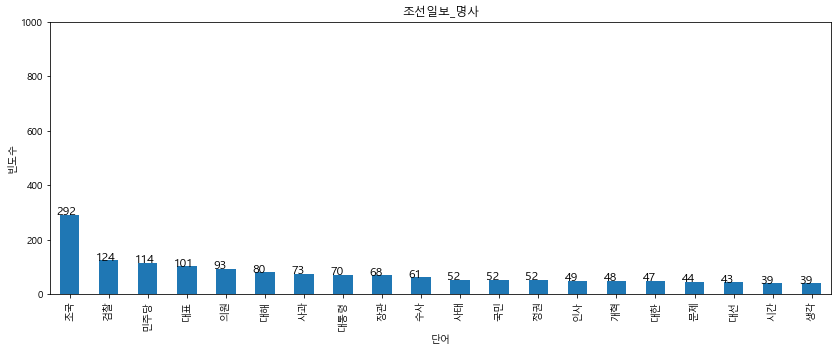

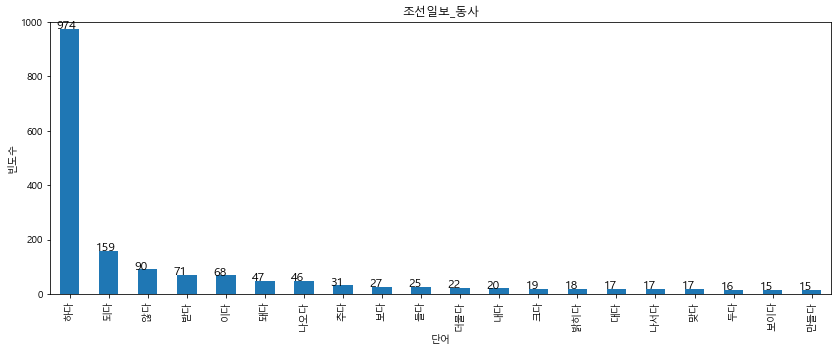

In [258]:
# 조선일보
# 품사별 분리
for pos in name_pos:  # "Noum", "Verb"  통계검색할 품사들

    print('조선일보', name_pos[pos])

    pos_words = []

    for mal in malist_chosun:   # mal <= (단어, 품사)
        if pos == mal[1] and len(mal[0]) > 1:   # 통계검색할 품사들만 and 단어길이가 2글자 이상만.
            pos_words.append(mal[0])  # 단어 추가

    pos_counter = Counter(pos_words)  # 해당 품사의 단어 빈도수 파악
    
    
    if pos == 'Noun':
        chosun_counter = Counter(pos_words)
    
    # 시각화를 위한 DataFrame 만들기
    df_freq = pd.DataFrame(columns = ['word', 'count'])

    for freq_words in pos_counter.most_common(20):  # 최다 빈도 상위20개 추출
        df_freq.loc[len(df_freq)] = (freq_words[0], freq_words[1])

    df_freq = df_freq.set_index('word') # 기존의 index 없애고 word 컬럼을 index 로 변경
    # 시각화
    plt.rcParams["figure.figsize"] = (14, 5)  # 그래프의 가로 세로 사이즈 기본설정
    ax = df_freq.plot(kind="bar")
    ax.set_title(f'조선일보_{name_pos[pos]}')
    ax.set_xlabel("단어")
    ax.set_ylabel("빈도수")
    ax.legend().set_visible(False)  # 범례 없애기
    ax.set_ylim(0, 1000)  # y 축 값 범위

    for i in ax.patches:  # 그래프에 해당 숫자 값 표시
        ax.text(
            i.get_x() - .08,  # 표시할 x 좌표
            i.get_height() + .5,  # 표시할 y 좌표
            i.get_height(),  # 표시할 값
            fontsize = 12,
            color = 'black'
        )       

동아일보 명사
동아일보 동사


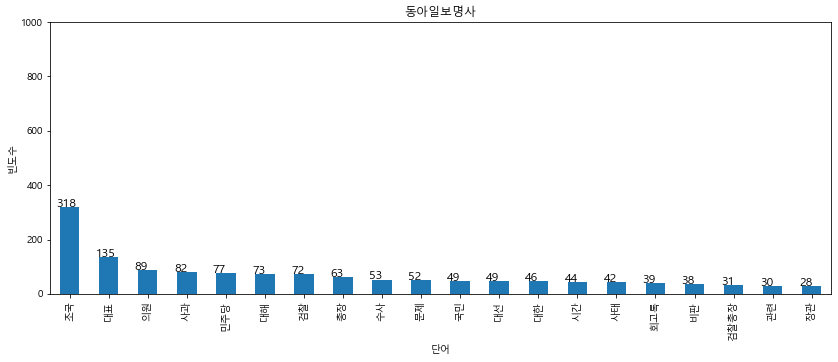

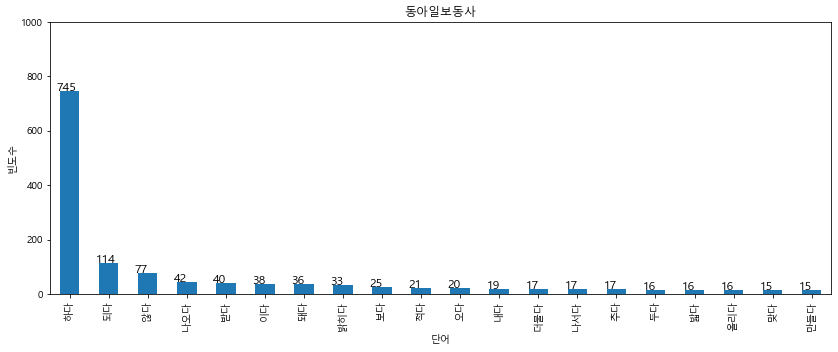

In [261]:
# 동아일보
# 품사별 분리
for pos in name_pos:  # "Noum", "Verb"  통계검색할 품사들

    print('동아일보', name_pos[pos])

    pos_words = []

    for mal in malist_donga:   # mal <= (단어, 품사)
        if pos == mal[1] and len(mal[0]) > 1:   # 통계검색할 품사들만 and 단어길이가 2글자 이상만.
            pos_words.append(mal[0])  # 단어 추가

    pos_counter = Counter(pos_words)  # 해당 품사의 단어 빈도수 파악
    
    if pos == 'Noun':
        donga_counter = pos_counter
        
    # 시각화를 위한 DataFrame 만들기
    df_freq = pd.DataFrame(columns = ['word', 'count'])

    for freq_words in pos_counter.most_common(20):  # 최다 빈도 상위20개 추출
        df_freq.loc[len(df_freq)] = (freq_words[0], freq_words[1])

    df_freq = df_freq.set_index('word') # 기존의 index 없애고 word 컬럼을 index 로 변경
    # 시각화
    plt.rcParams["figure.figsize"] = (14, 5)  # 그래프의 가로 세로 사이즈 기본설정
    ax = df_freq.plot(kind="bar")
    ax.set_title(f'동아일보{name_pos[pos]}')
    ax.set_xlabel("단어")
    ax.set_ylabel("빈도수")
    ax.legend().set_visible(False)  # 범례 없애기
    ax.set_ylim(0, 1000)  # y 축 값 범위

    for i in ax.patches:  # 그래프에 해당 숫자 값 표시
        ax.text(
            i.get_x() - .08,  # 표시할 x 좌표
            i.get_height() + .5,  # 표시할 y 좌표
            i.get_height(),  # 표시할 값
            fontsize = 12,
            color = 'black'
        )


경향신문 명사
경향신문 동사


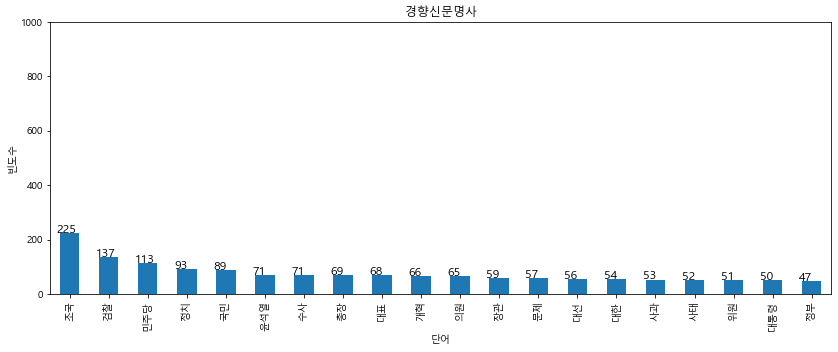

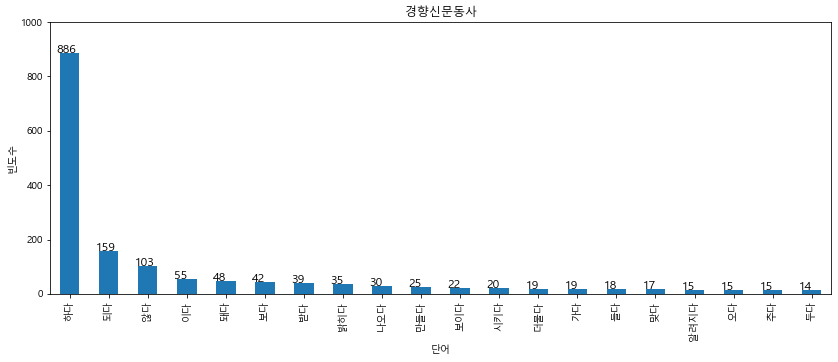

In [265]:
# 경향신문
# 품사별 분리
for pos in name_pos:  # "Noum", "Verb"  통계검색할 품사들

    print('경향신문', name_pos[pos])

    pos_words = []

    for mal in malist_kyunghyang:   # mal <= (단어, 품사)
        if pos == mal[1] and len(mal[0]) > 1:   # 통계검색할 품사들만 and 단어길이가 2글자 이상만.
            pos_words.append(mal[0])  # 단어 추가

    pos_counter = Counter(pos_words)  # 해당 품사의 단어 빈도수 파악
    
    if pos == 'Noun':
        kyunghyang_counter = pos_counter
        
    # 시각화를 위한 DataFrame 만들기
    df_freq = pd.DataFrame(columns = ['word', 'count'])

    for freq_words in pos_counter.most_common(20):  # 최다 빈도 상위20개 추출
        df_freq.loc[len(df_freq)] = (freq_words[0], freq_words[1])

    df_freq = df_freq.set_index('word') # 기존의 index 없애고 word 컬럼을 index 로 변경
    # 시각화
    plt.rcParams["figure.figsize"] = (14, 5)  # 그래프의 가로 세로 사이즈 기본설정
    ax = df_freq.plot(kind="bar")
    ax.set_title(f'경향신문{name_pos[pos]}')
    ax.set_xlabel("단어")
    ax.set_ylabel("빈도수")
    ax.legend().set_visible(False)  # 범례 없애기
    ax.set_ylim(0, 1000)  # y 축 값 범위

    for i in ax.patches:  # 그래프에 해당 숫자 값 표시
        ax.text(
            i.get_x() - .08,  # 표시할 x 좌표
            i.get_height() + .5,  # 표시할 y 좌표
            i.get_height(),  # 표시할 값
            fontsize = 12,
            color = 'black'
        )


한겨례 명사
한겨례 동사


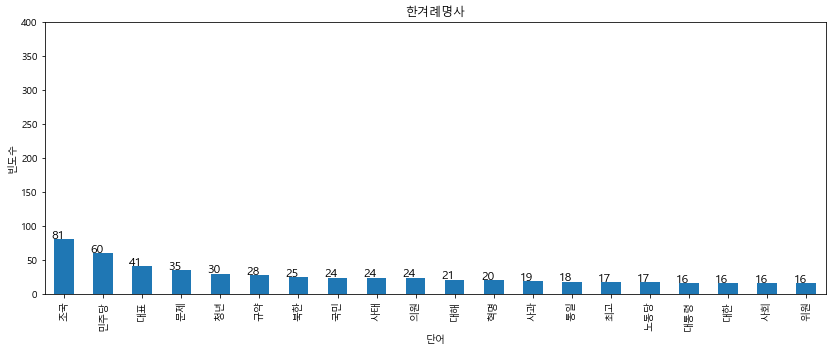

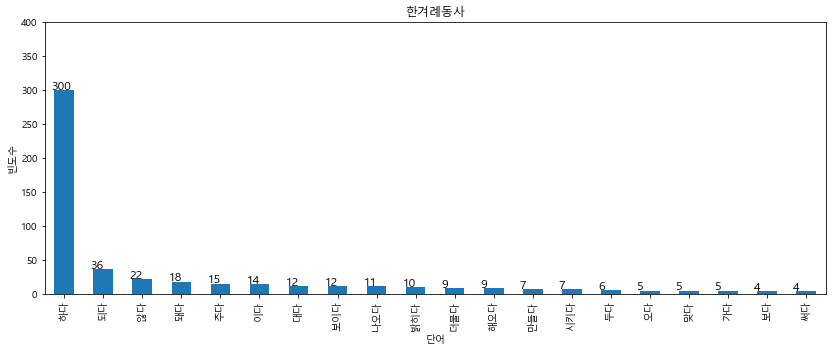

In [266]:
# 한겨례 명사
# 품사별 분리
for pos in name_pos:  # "Noum", "Verb"  통계검색할 품사들

    print('한겨례', name_pos[pos])

    pos_words = []

    for mal in malist_hankyoreh:   # mal <= (단어, 품사)
        if pos == mal[1] and len(mal[0]) > 1:   # 통계검색할 품사들만 and 단어길이가 2글자 이상만.
            pos_words.append(mal[0])  # 단어 추가

    pos_counter = Counter(pos_words)  # 해당 품사의 단어 빈도수 파악

    if pos == 'Noun':
        hankyoreh_counter = pos_counter
    
    # 시각화를 위한 DataFrame 만들기
    df_freq = pd.DataFrame(columns = ['word', 'count'])

    for freq_words in pos_counter.most_common(20):  # 최다 빈도 상위20개 추출
        df_freq.loc[len(df_freq)] = (freq_words[0], freq_words[1])

    df_freq = df_freq.set_index('word') # 기존의 index 없애고 word 컬럼을 index 로 변경
    # 시각화
    plt.rcParams["figure.figsize"] = (14, 5)  # 그래프의 가로 세로 사이즈 기본설정
    ax = df_freq.plot(kind="bar")
    ax.set_title(f'한겨례{name_pos[pos]}')
    ax.set_xlabel("단어")
    ax.set_ylabel("빈도수")
    ax.legend().set_visible(False)  # 범례 없애기
    ax.set_ylim(0, 400)  # y 축 값 범위

    for i in ax.patches:  # 그래프에 해당 숫자 값 표시
        ax.text(
            i.get_x() - .08,  # 표시할 x 좌표
            i.get_height() + .5,  # 표시할 y 좌표
            i.get_height(),  # 표시할 값
            fontsize = 12,
            color = 'black'
        )

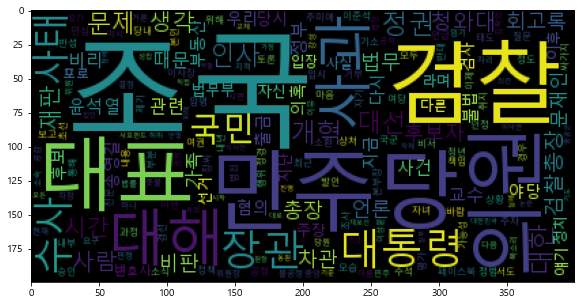

In [260]:
# 조선일보 명사 wordcloud
cloud = wc.generate_from_frequencies(chosun_counter)
plt.imshow(cloud)
plt.show()

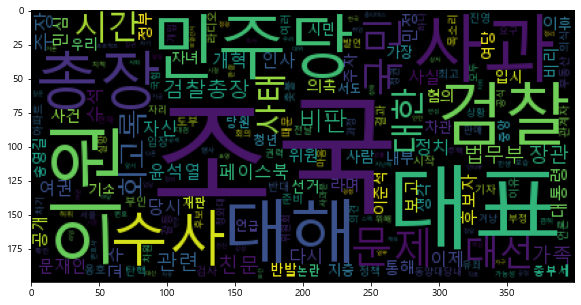

In [262]:
# 동아일보 명사 wordcloud
cloud = wc.generate_from_frequencies(donga_counter)
plt.imshow(cloud)
plt.show()

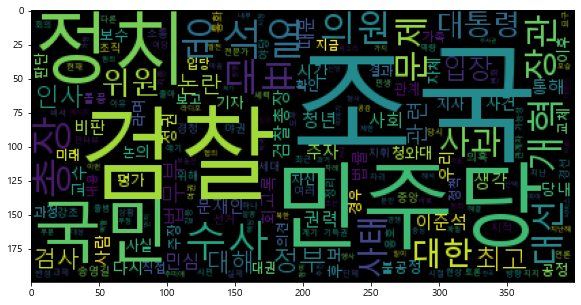

In [264]:
# 경향신문 명사 wordcloud
cloud = wc.generate_from_frequencies(kyunghyang_counter)
plt.imshow(cloud)
plt.show()

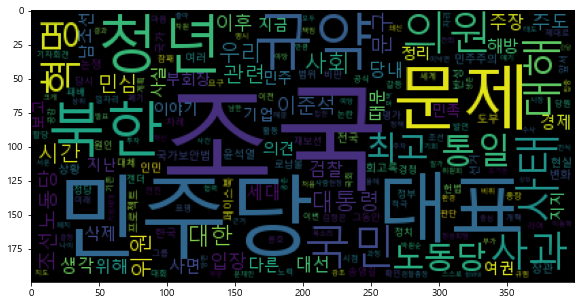

In [267]:
# 한겨례 명사 wordcloud
cloud = wc.generate_from_frequencies(hankyoreh_counter)
plt.imshow(cloud)
plt.show()

# 5. 정형데이터화
- **언론사별**로  기사 텍스트를 Word2Vec 모델을 적용 학습시켜 벡터화 합니다


- 이후 언론사별로 '조국' 이라는 단어와 가장 가까운 단어들이 무엇인지 출력해보세요

In [324]:
word2vec.Word2Vec

gensim.models.word2vec.Word2Vec

In [329]:
article = "".join(df_chosun['정제본문'])
wakati_file = r'C:\DevRoot\DataSet\news\df_chosun.wakati'
with open(wakati_file, 'w', encoding='utf-8') as fp:
    fp.write(article)
data = word2vec.LineSentence(wakati_file)
model = word2vec.Word2Vec(data, vector_size=200, window=10, hs=1, min_count=2, sg=1)
save_path = r'C:\DevRoot\DataSet\news\df_chosun.model'
model.save(save_path)
del(model)
chosun_model = word2vec.Word2Vec.load(save_path)

ok


In [332]:
article = "".join(df_donga['정제본문'])
wakati_file = r'C:\DevRoot\DataSet\news\df_donga.wakati'
with open(wakati_file, 'w', encoding='utf-8') as fp:
    fp.write(article)
data = word2vec.LineSentence(wakati_file)
model = word2vec.Word2Vec(data, vector_size=200, window=10, hs=1, min_count=2, sg=1)
save_path = r'C:\DevRoot\DataSet\news\df_donga.model'
model.save(save_path)
del(model)
donga_model = word2vec.Word2Vec.load(save_path)

In [334]:
article = "".join(df_kyunghyang['정제본문'])
wakati_file = r'C:\DevRoot\DataSet\news\df_kyunghyang.wakati'
with open(wakati_file, 'w', encoding='utf-8') as fp:
    fp.write(article)
data = word2vec.LineSentence(wakati_file)
model = word2vec.Word2Vec(data, vector_size=200, window=10, hs=1, min_count=2, sg=1)
save_path = r'C:\DevRoot\DataSet\news\df_kyunghyang.model'
model.save(save_path)
del(model)
kyunghyang_model = word2vec.Word2Vec.load(save_path)

In [338]:
article = "".join(df_hankyoreh['정제본문'])
wakati_file = r'C:\DevRoot\DataSet\news\df_hankyoreh.wakati'
with open(wakati_file, 'w', encoding='utf-8') as fp:
    fp.write(article)
data = word2vec.LineSentence(wakati_file)
model = word2vec.Word2Vec(data, vector_size=200, window=10, hs=1, min_count=2, sg=1)
save_path = r'C:\DevRoot\DataSet\news\df_hankyoreh.model'
model.save(save_path)
del(model)
hankyoreh_model = word2vec.Word2Vec.load(save_path)

In [331]:
# 조선일보
chosun_model.wv.most_similar(positive=['조국'])

[('민주당', 0.9748954176902771),
 ('이른바', 0.9738817811012268),
 ('민심', 0.9733888506889343),
 ('민주당은', 0.9731850624084473),
 ('문제는', 0.9729486107826233),
 ('다', 0.9691213369369507),
 ('주장을', 0.9686923027038574),
 ('민주당에서', 0.9659001231193542),
 ('대해서도', 0.9652330279350281),
 ('대국민', 0.9651808738708496)]

In [333]:
# 동아일보
donga_model.wv.most_similar(positive=['조국'])

[('더불어민주당', 0.9517236948013306),
 ('번째다.', 0.9510552287101746),
 ('가세했다.', 0.9497014284133911),
 ('사과했으니', 0.9475915431976318),
 ('여부에', 0.9470897912979126),
 ('인사는', 0.9428027272224426),
 ('의견은', 0.9426296949386597),
 ('한결', 0.9424843192100525),
 ('오만하게', 0.9417223930358887),
 ('가르치려고', 0.9410718679428101)]

In [335]:
# 경향신문
kyunghyang_model.wv.most_similar(positive=['조국'])

[('의원들은', 0.975287914276123),
 ('일부', 0.9721218943595886),
 ('관련한', 0.9712409377098083),
 ('그러면서', 0.9676076173782349),
 ('사과', 0.9655990600585938),
 ('참패', 0.9653645157814026),
 ('분석도', 0.9652122259140015),
 ('대선을', 0.9650399684906006),
 ('회고록과', 0.964563250541687),
 ('있다는', 0.9628989696502686)]

In [339]:
# 한겨레
hankyoreh_model.wv.most_similar(positive=['조국'])

[('있다.', 0.9981274604797363),
 ('수', 0.997568666934967),
 ('민주당은', 0.9971203207969666),
 ('없다.', 0.997094452381134),
 ('그런', 0.996836245059967),
 ('한다고', 0.9965503811836243),
 ('돼', 0.9963337779045105),
 ('나온다.', 0.9963233470916748),
 ('관련한', 0.9962620735168457),
 ('있는', 0.9961498975753784)]